# Company Reviews Analysis

Kaggle에 있는 Blind에 올라온 기업 review data를 바탕으로, 해외 기업별 분위기 및 퇴사 이유 등을 분석해보고,
기업별 점수대 비교 등을 진행해보고자 한다.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Review_data example check

예시로, apple 리뷰 데이터를 한번 열람해보자.

In [2]:
sample_file = 'C:/Users/USER/Desktop/Data_projects/Company_Review_Analysys/reviews/Apple/apple-data.csv'
sample_df = pd.read_csv(sample_file)

In [3]:
sample_df

,Rating,Description,Pros,Cons,Author Info,Resignation Reason
0,3,Great projects but terrible wlb,Great projectsSmart engineersEveryone works ha...,"No wlbNo remoteNo perks, just desk and wallsEv...",Verified User Current Employee W********* Acqu...,NaN
1,4,Good company overall,Good Job security. Never heard of layoffs. Goo...,Frequent re-orgs. Mandatory return to office p...,Verified User Current Employee q***** Software...,NaN
2,5,A,"Good company, strong leader ship, believe in t...",No free food No hybrid work culture No perks p...,Verified User Current Employee C********* Engi...,NaN
3,5,Great company in general,Immediate managers are caringAble to start and...,Job is very monotonousNot much opportunities t...,Verified User Current Employee h********* Cont...,NaN
4,4,Poor wlb,"Smart engineers, challenging problems, cloud a...","Limited growth, lots of politics, no wfh, comp...",Verified User Current Employee G***** Engineer...,NaN
...,...,...,...,...,...,...
1792,3,Depends on your team,"Great benefits, great perks. Fun company-wide ...",It was really difficult to work with my team. ...,Verified User Current Employee u********* Mach...,NaN
1793,3,Wasn't the best,You have the opportunity to work with really s...,Zero opportunity for growth. It's difficult to...,Verified User Former Employee g***** Marketing...,Found a senior role at another company
1794,4,Dynamic Workplace,It's definitely not easy work. Things are alwa...,Work pressure is high. This can get really str...,Verified User Current Employee r***** Systems ...,NaN
1795,5,"""Great company with a culture that takes getti...",One thing I’ve learned from talking to people ...,"As with lots of tech companies, there are many...",Verified User Current Employee B***** Software...,NaN


- Rating : 회사에 대한 평가
- Description : 총평 요약
- Pros : 장점.
- cons : 단점.
- Author Info : 쓴 사람에 대한 정보.
- Resignation Reason : 퇴사 이유

In [4]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Rating              1797 non-null   int64 
 1   Description         1797 non-null   object
 2   Pros                1797 non-null   object
 3   Cons                1797 non-null   object
 4   Author Info         1797 non-null   object
 5   Resignation Reason  54 non-null     object
dtypes: int64(1), object(5)
memory usage: 84.4+ KB


다음은 Author info를 확인해 보자.

In [5]:
sample_df['Author Info'][0]

'Verified User Current Employee W********* Acquisition Program Manager - May 6, 2022'

우선, Current / Former로 전직자, 현직자를 구분할 수 있으며 이름은 익명처리 되어있다.
직무가 무엇인지 적혀있고, 리뷰를 적은 날짜를 알 수 있다.

## 리뷰에 들어가는 단어 익히기

이런데 특성상, 약어가 많을 것이다. 약어를 어떻게 처리할 것인지에 대해 고민해야 하기에, 리뷰를 직접 읽어보며 전처리해야 할 것이다.

In [6]:
sample_df.Description[:10]

0                      Great projects but terrible wlb
1                                 Good company overall
2                                                    A
3                             Great company in general
4                                             Poor wlb
5                    I like working here and it’s IS&T
6    I was a contract designer so my feedback is ba...
7                     Minimal perks and average salary
8                                  Top down management
9                            Operates in its own style
Name: Description, dtype: object

- perks : Perquisite, 급료 이외의 보너스.
- wlb :work life balance

분석할 수 있는 문제에 대해 고민해보고자 한다.
- 회사별 퇴사 비율 / 평점 비교
- 회사별 퇴사자들의 리뷰 분석
- 회사별 장점 / 단점 주요 어휘 분석

## 회사별 퇴사 비율 / 평점 비교

모든 회사에 대해서 다루기는 방대하므로, 적당히 몇개의 예시를 비교하려고 한다.
이를 위해서는 퇴사비율과 평점에 대한 비교는 필수적이다.

In [7]:
sample_df.Rating.value_counts()

4    817
5    542
3    334
2     72
1     32
Name: Rating, dtype: int64

In [8]:
sample_df['Resignation Reason'].isna().sum()

1743

위의 두가지를 응용하여, dataframe을 만들려고 하다.

In [9]:
company_df = pd.DataFrame(columns = ['company', 'r1', 'r2', 'r3', 'r4', 'r5', 'avg_rate', 'low_rate', 'total_reviews',
                        'resign_counts', 'resign_rate'])

In [10]:
company_list = ['Adobe', 'Airbnb', 'Amazon', 'Apple', 'Atlassian',
               'Bloomberg', 'Bytedance', 'Cisco', 'Coinbase',
               'Deloitte', 'Goldman-Sachs', 'Google', 'IBM',
               'Intel', 'Intuit', 'Meta', 'Microsoft', 'Netflix',
               'Oracle', 'Salesforce', 'SAP-Labs', 'Stripe',
               'Twitter', 'Uber', 'Walmart']
root_folder = 'C:/Users/USER/Desktop/Data_projects/Company_Review_Analysys/reviews/'
# file명은 company_list의 소문자에 -data가 붙여져 나온다.
for i in range(len(company_list)):
    cur_comp = company_list[i]
    
    cur_file = root_folder +company_list[i]+'/'+company_list[i].lower()+'-data.csv'
    cur_df = pd.read_csv(cur_file)
    
    cur_ratings = cur_df.Rating.value_counts()
    r1 = cur_ratings[1]
    r2 = cur_ratings[2]
    r3 = cur_ratings[3]
    r4 = cur_ratings[4]
    r5 = cur_ratings[5]
    
    
    cur_total_reviews = len(cur_df)
    avg_rate = (r1 + 2*r2 + 3*r3 + 4*r4 + 5*r5)/cur_total_reviews
    cur_resigns = cur_total_reviews - cur_df['Resignation Reason'].isna().sum()
    cur_resign_rate = cur_resigns / cur_total_reviews
    low_rate = (r1 + r2)/cur_total_reviews
    
    company_df.loc[i] = [cur_comp, r1, r2, r3, r4, r5, avg_rate, low_rate,
                         cur_total_reviews, cur_resigns, cur_resign_rate]

In [11]:
company_df

,company,r1,r2,r3,r4,r5,avg_rate,low_rate,total_reviews,resign_counts,resign_rate
0,Adobe,23,23,127,430,351,4.114256,0.048218,954,20,0.020964
1,Airbnb,29,34,121,197,134,3.724272,0.122330,515,17,0.033010
2,Amazon,799,1029,3393,3658,1018,3.309892,0.184702,9897,247,0.024957
3,Apple,32,72,334,817,542,3.982193,0.057874,1797,54,0.030050
4,Atlassian,4,15,47,172,220,4.286026,0.041485,458,9,0.019651
5,Bloomberg,17,29,187,618,265,3.972222,0.041219,1116,26,0.023297
6,Bytedance,70,91,225,197,105,3.255814,0.234012,688,28,0.040698
7,Cisco,39,85,475,643,246,3.653226,0.083333,1488,41,0.027554
8,Coinbase,23,14,48,99,121,3.921311,0.121311,305,6,0.019672
9,Deloitte,33,76,346,452,140,3.563515,0.104107,1047,39,0.037249


우선 보이는 부분만 정리하면 다음과 같다.
- 대체적으로 3점 이상의 평점, 5% 미만의 퇴사율을 보이고 있다.
- 평점은 대체로 3~4점에 분포되어 있음을 알 수 있다.

시각화를 통해서 몇 가지를 간단하게 확인해보자.

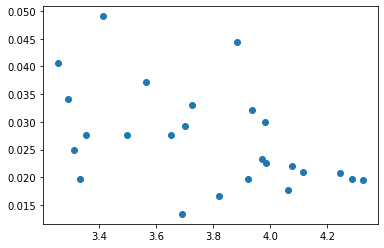

In [12]:
plt.scatter(company_df.avg_rate, company_df.resign_rate)

데이터가 적어서일수도 있지만, 상대적으로 낮은 평점을 보인 기업에서 퇴사율이 2배 이상 차이가 난다.
따라서, 단순 평균 평점이 낮다고 퇴사율이 높은 회사라고 말할수는 없어보인다.

2점 이상의 낮은 평점 비율이 높을수록 퇴사율이 높은지 시각화를 통해 확인해보고자 한다.

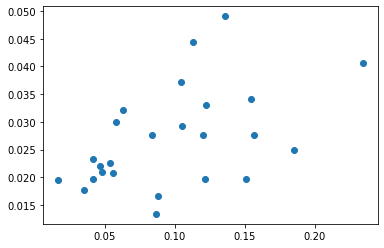

In [13]:
plt.scatter(company_df.low_rate, company_df.resign_rate)

위의 그림에 비해서는, 조금 더 상관관계가 보인다. 실제로 corr를 계산해서 상관관계가 어느정도인지를 확인하자.

In [14]:
# 평균 평점과 퇴사율의 상관관계 계산
np.corrcoef(company_df.avg_rate, company_df.resign_rate)

array([[ 1.        , -0.46375178],
       [-0.46375178,  1.        ]])

In [15]:
# 평균 평점과 퇴사율의 상관관계 계산
np.corrcoef(company_df.low_rate, company_df.resign_rate)

array([[1.        , 0.49622035],
       [0.49622035, 1.        ]])

실제로는 두 상관관계가 굉장히 비슷하지만, 상관관계가 크게 높지 않다는 것을 알 수 있다.
리뷰의 내용을 바탕으로 조금더 

## sample_df인 apple data를 활용한 전처리 및 예측 모델 생성 계획 수립

### 퇴사 예측

In [16]:
sample_df

,Rating,Description,Pros,Cons,Author Info,Resignation Reason
0,3,Great projects but terrible wlb,Great projectsSmart engineersEveryone works ha...,"No wlbNo remoteNo perks, just desk and wallsEv...",Verified User Current Employee W********* Acqu...,NaN
1,4,Good company overall,Good Job security. Never heard of layoffs. Goo...,Frequent re-orgs. Mandatory return to office p...,Verified User Current Employee q***** Software...,NaN
2,5,A,"Good company, strong leader ship, believe in t...",No free food No hybrid work culture No perks p...,Verified User Current Employee C********* Engi...,NaN
3,5,Great company in general,Immediate managers are caringAble to start and...,Job is very monotonousNot much opportunities t...,Verified User Current Employee h********* Cont...,NaN
4,4,Poor wlb,"Smart engineers, challenging problems, cloud a...","Limited growth, lots of politics, no wfh, comp...",Verified User Current Employee G***** Engineer...,NaN
...,...,...,...,...,...,...
1792,3,Depends on your team,"Great benefits, great perks. Fun company-wide ...",It was really difficult to work with my team. ...,Verified User Current Employee u********* Mach...,NaN
1793,3,Wasn't the best,You have the opportunity to work with really s...,Zero opportunity for growth. It's difficult to...,Verified User Former Employee g***** Marketing...,Found a senior role at another company
1794,4,Dynamic Workplace,It's definitely not easy work. Things are alwa...,Work pressure is high. This can get really str...,Verified User Current Employee r***** Systems ...,NaN
1795,5,"""Great company with a culture that takes getti...",One thing I’ve learned from talking to people ...,"As with lots of tech companies, there are many...",Verified User Current Employee B***** Software...,NaN


우선은 매우 간단하게, Tf_Idf를 활용하려고 한다.
이를 위해서 퇴사 여부 변수를 만들고, train/test set을 만들어 학습하다.

In [29]:
# step 1/ Resign 여부 만들기
sample_df['resign'] = sample_df['Resignation Reason'].apply(lambda x : 0 if  pd.isna(x) == True else 1)

In [30]:
sample_df

,Rating,Description,Pros,Cons,Author Info,Resignation Reason,resign
0,3,Great projects but terrible wlb,Great projectsSmart engineersEveryone works ha...,"No wlbNo remoteNo perks, just desk and wallsEv...",Verified User Current Employee W********* Acqu...,NaN,0
1,4,Good company overall,Good Job security. Never heard of layoffs. Goo...,Frequent re-orgs. Mandatory return to office p...,Verified User Current Employee q***** Software...,NaN,0
2,5,A,"Good company, strong leader ship, believe in t...",No free food No hybrid work culture No perks p...,Verified User Current Employee C********* Engi...,NaN,0
3,5,Great company in general,Immediate managers are caringAble to start and...,Job is very monotonousNot much opportunities t...,Verified User Current Employee h********* Cont...,NaN,0
4,4,Poor wlb,"Smart engineers, challenging problems, cloud a...","Limited growth, lots of politics, no wfh, comp...",Verified User Current Employee G***** Engineer...,NaN,0
...,...,...,...,...,...,...,...
1792,3,Depends on your team,"Great benefits, great perks. Fun company-wide ...",It was really difficult to work with my team. ...,Verified User Current Employee u********* Mach...,NaN,0
1793,3,Wasn't the best,You have the opportunity to work with really s...,Zero opportunity for growth. It's difficult to...,Verified User Former Employee g***** Marketing...,Found a senior role at another company,1
1794,4,Dynamic Workplace,It's definitely not easy work. Things are alwa...,Work pressure is high. This can get really str...,Verified User Current Employee r***** Systems ...,NaN,0
1795,5,"""Great company with a culture that takes getti...",One thing I’ve learned from talking to people ...,"As with lots of tech companies, there are many...",Verified User Current Employee B***** Software...,NaN,0


여러가지를 보려고 하지만, 일단은 Description만을 활용해보려고 한다.
이 때, 대문자는 모두 소문자로 치환해서 보면 편할 것이다.

In [34]:
# resign 비율이 높지는 않으므로, 즉 imbalanced 되었다.
# 따라서 stratify를 반드시 설정해야 한다.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sample_df.Description, sample_df.resign, test_size=0.2, 
                                                    shuffle=True, stratify=sample_df.resign, random_state=42)

모델은, 우선은 naive bayes를 활용한다.
naive bayes를 통해 기대해볼 수 있는 것은, 특정 단어가 리뷰에 등장할때 퇴사율 예측에 얼마나 예측을 줄지를 볼 수 있다.

In [44]:
# 전처리 및 평가함수 정의, 학습과정
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(lowercase = False)
x_train_v = vectorizer.fit_transform(x_train)
x_test_v = vectorizer.transform(x_test)

nb = MultinomialNB(alpha = 0.005)
nb.fit(x_train_v, y_train)
pred = nb.predict(x_test_v)
print(f1_score(y_test, pred))

0.0


In [45]:
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

잉? 모두 0이다... 왜그럴까?

In [48]:
sum(y_test)

11

저 수많은 데이터 중, 단 11개를 찾는 imbalanced된 문제가 보인다.
imbalanced에서는 naive bayes가 매우 약한 것으로 추정된다.

### rating 예측 문제

rating 예측 문제에선 어떨지? 확인해보자.

In [49]:
from sklearn.model_selection import train_test_split
x_train_rate, x_test_rate, y_train, y_test = train_test_split(sample_df.Description, sample_df.Rating, test_size=0.2, 
                                                    shuffle=True, stratify=sample_df.Rating, random_state=42)

In [51]:
vectorizer = TfidfVectorizer(lowercase = False)
x_train_rate_v = vectorizer.fit_transform(x_train_rate)
x_test_rate_v = vectorizer.transform(x_test_rate)

nb = MultinomialNB(alpha = 0.05)
nb.fit(x_train_rate_v, y_train)
pred = nb.predict(x_test_rate_v)
print(f1_score(y_test, pred, average='weighted'))

0.41911541460736196


예측이 실제로 어떻게 이루어지고 있나 확인해보자.

In [52]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

array([[  0,   1,   0,   4,   1],
       [  0,   0,   4,   6,   4],
       [  0,   0,  11,  49,   7],
       [  0,   0,  13, 109,  42],
       [  0,   2,   8,  57,  42]], dtype=int64)

rating이 낮은 값들에 대해서 예측이 잘 안 맞는 느낌이 강하다.
이의 이유는 다음과 같다고 생각할 수 있을 것이다.

- wlb와 no wlb 등 단순히 단어를 tf-idf만 줘서는, 좋은 예측을 하기에 어려울 것이다.  -> n-gram을 통한 극복으로 가능.
- 그 외 기본적인 전처리나 토큰화가 이루어지지 않아, 유의미하다고 보기가 어렵다.

전처리 계획을 바탕으로 문제를 해결하고자 한다.

### 추가 전처리 진행하기

## 다른 기업에도 이 모델이 잘 적용될까?

## 전체를 예측하기 위한 모델링

## 더 어려운 모델 써보기